In [ ]:
from datasets import load_dataset
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

ds = load_dataset("mandarjoshi/trivia_qa", "rc")['validation']

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def simplify(example):
    return {
        "id": example["question_id"],
        "question": example["question"],
        "normalized_aliases": example["answer"]["normalized_aliases"]
    }

simplified_ds = ds.map(simplify, remove_columns=ds.column_names)
print(simplified_ds[1])

{'question': 'Which Lloyd Webber musical premiered in the US on 10th December 1993?', 'id': 'tc_33', 'normalized_aliases': ['sunset boulevard', 'sunset bulevard', 'west sunset boulevard', 'sunset blvd']}


In [ ]:
trivia_sample = simplified_ds.shuffle(seed=42).select(range(1000))
trivia_sample.to_json("trivia_sample_raw.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

380799

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

# QA implementations

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="classified_TriviaQA_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="classified_TriviaQA_sample_FS.jsonl",
    split="train"
)

## Loading GPT for short QA

In [3]:
from openai import OpenAI

client = OpenAI(
    api_key="",
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
) # Delete when sharing

In [4]:
def ask_short_answer(question, client, model="gemini-2.5-flash", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with concise responses. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return ["[Error]: Max retries exceeded"]

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

In [6]:
def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=5, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

## Implementations

In [7]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gemini-2.5-flash",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


In [8]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gemini-2.5-flash",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 181/181 [33:53<00:00, 11.23s/it]   


In [9]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])

qa_underspecified.to_json("TriviaQA_UND_qa_Gemini.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

83965

In [10]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])

qa_fully_specified.to_json("TriviaQA_FS_qa_Gemini.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

760764

In [11]:
df = pd.read_json("TriviaQA_UND_qa_Gemini.jsonl", lines=True)
df.to_csv('TriviaQA_UND_qa_Gemini.csv')

df = pd.read_json("TriviaQA_FS_qa_Gemini.jsonl", lines=True)
df.to_csv('TriviaQA_FS_qa_Gemini.csv')

# Evaluations

In [12]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="TriviaQA_UND_qa_Gemini.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="TriviaQA_FS_qa_Gemini.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Squad EM + F1

In [13]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="TriviaQA_FS_qa_Gemini.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["normalized_aliases"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 80.49
F1 Score: 88.18


In [22]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="TriviaQA_UND_qa_Gemini.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["normalized_aliases"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 74.49
F1 Score: 82.19


In [14]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="normalized_aliases"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [15]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("TriviaQA_UND_qa_Gemini_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

85606

In [16]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("TriviaQA_FS_qa_Gemini_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

775846

In [17]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 74.49
UND F1 Score (avg): 82.19
FS Exact Match (avg): 80.49
FS F1 Score (avg): 88.18
F1: t=1.663, p=0.0991
EM: t=1.299, p=0.1967


In [3]:
UND_full = load_dataset(
    "json",
    data_files="TriviaQA_UND_qa_Gemini_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="TriviaQA_FS_qa_Gemini_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
df = pd.read_json("TriviaQA_UND_qa_Gemini_with_squad_scores.jsonl", lines=True)
df.to_csv('TriviaQA_UND_qa_Gemini_with_squad_scores.csv')

df = pd.read_json("TriviaQA_FS_qa_Gemini_with_squad_scores.jsonl", lines=True)
df.to_csv('TriviaQA_FS_qa_Gemini_with_squad_scores.csv')

In [4]:
print(f'Gemini 2.5 Flash TriviaQA NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'Gemini 2.5 Flash TriviaQA NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'Gemini 2.5 Flash TriviaQA NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'Gemini 2.5 Flash TriviaQA NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

Gemini 2.5 Flash TriviaQA NQ UND qa EM SD: 0.4359185584345679
Gemini 2.5 Flash TriviaQA NQ FS qa EM SD: 0.39629455632370536
Gemini 2.5 Flash TriviaQA NQ UND qa F1 SD: 0.342373972863357
Gemini 2.5 Flash TriviaQA NQ FS qa F1 SD: 0.27905016059382337


In [5]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [6]:
welch_df(98, np.std(UND_full["em"]), 902, np.std(FS_full["em"]))

115.10213088670186

In [7]:
welch_df(98, np.std(UND_full["f1"]), 902, np.std(FS_full["f1"]))

111.444601956536

## Visualization

In [18]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("Gemini 2.5 Flash F1 Score Distribution by Subset - TriviaQA")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("TriviaQA_f1_boxplot_Gemini.png", dpi=300)
plt.close()

/scratch-local/yhuang.13034533/ipykernel_1322220/2266997364.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)


In [23]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("Gemini 2.5 Flash F1 Score Distribution by Subset - TriviaQA")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("TriviaQA_f1_boxplot_Gemini.png", dpi=300)
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("Gemini-2.5-Flash Exact Match Rate by Subset (± CI) - TriviaQA")
plt.tight_layout()
plt.savefig("TriviaQA_em_barplot_Gemini.png",dpi=300)
plt.close()

/scratch-local/yhuang.13034533/ipykernel_1322220/4122781730.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.13034533/ipykernel_1322220/4122781730.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.13034533/ipykernel_1322220/4122781730.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


In [ ]:
from IPython.display import Image
Image("TriviaQA_f1_boxplot_Gemini.png")

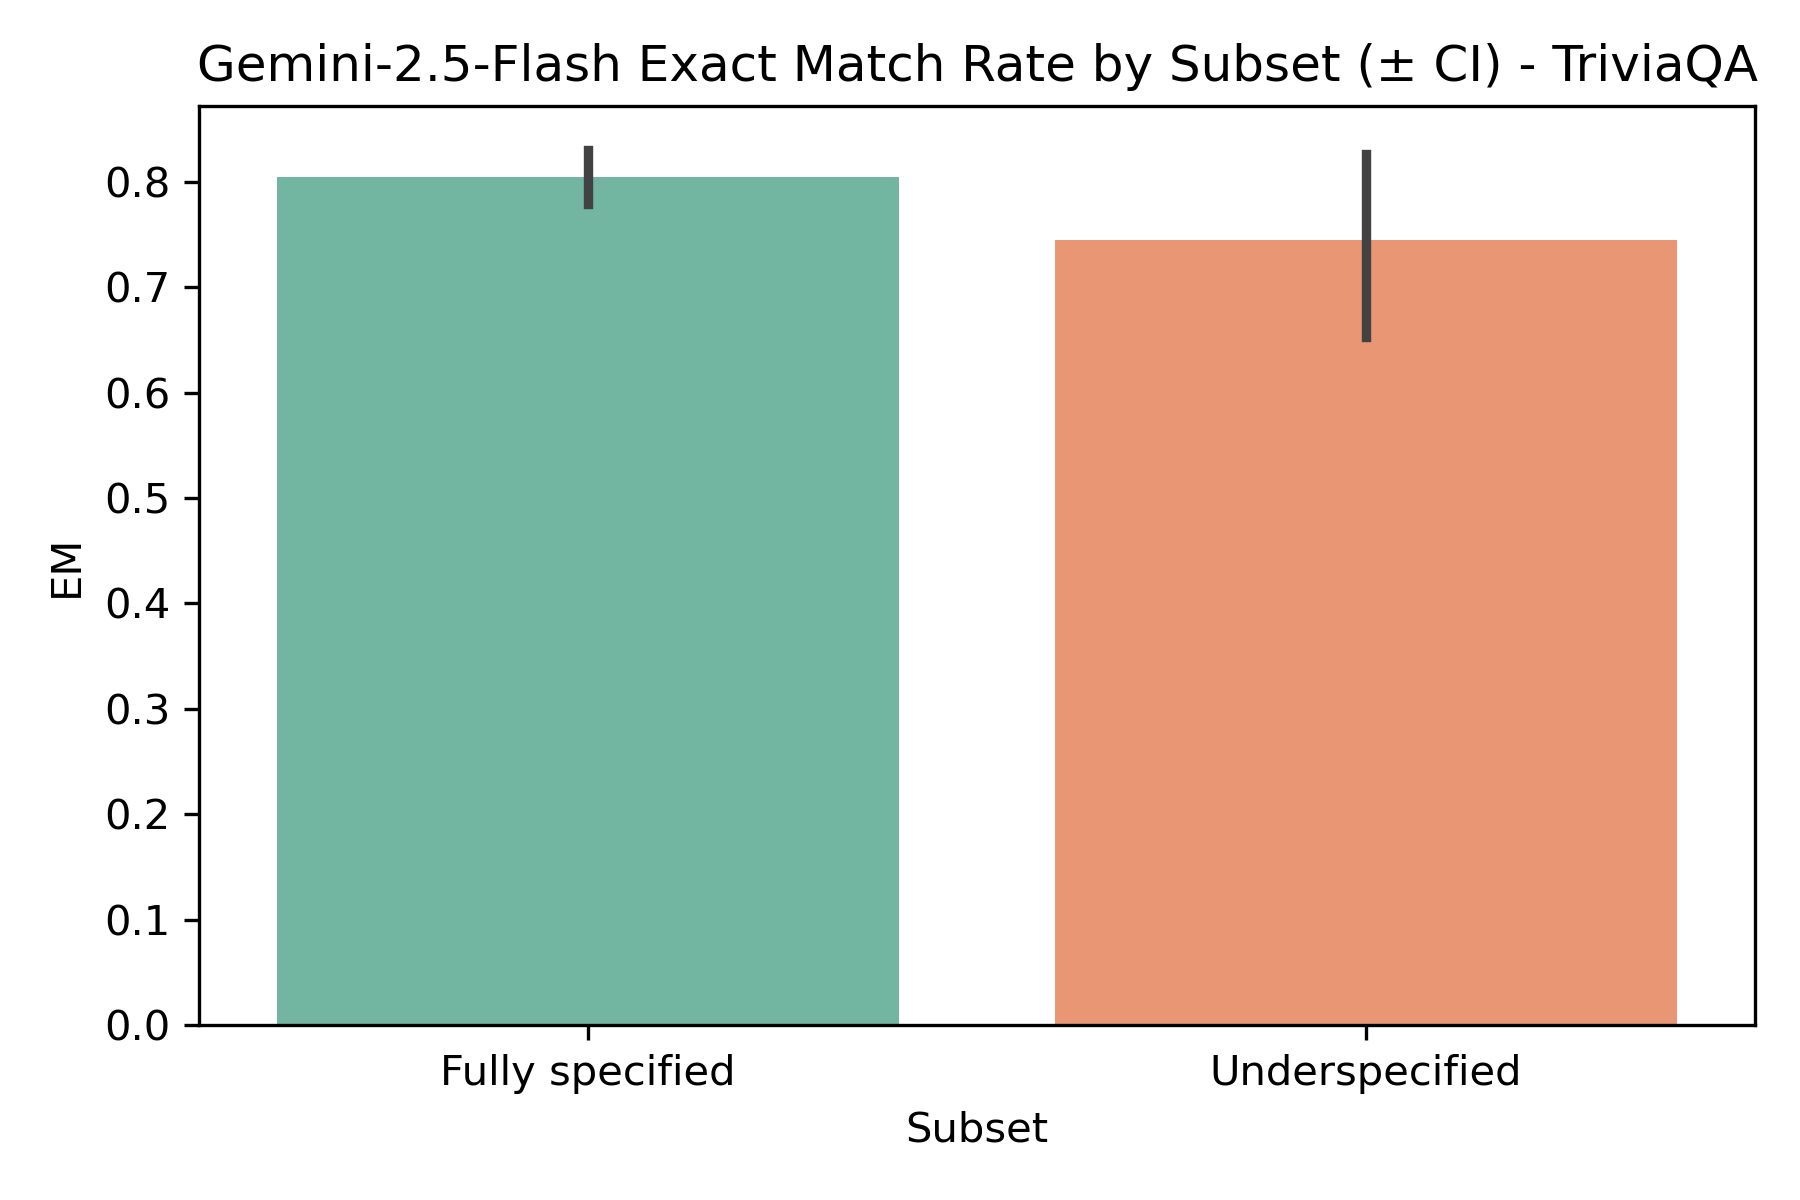

In [24]:
Image("TriviaQA_em_barplot_Gemini.png")

In [25]:
# 设置学术风格
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(6.5, 4.5))

# Violin plot 只显示分布，不显示 quartile
sns.violinplot(
    x="Subset", y="F1", data=df_f1,
    palette="Set2", inner=None, cut=0
)

# 叠加 boxplot 显示中位数和 IQR，透明一点避免遮住 violin
sns.boxplot(
    x="Subset", y="F1", data=df_f1,
    width=0.2, showcaps=True, boxprops={'facecolor':'white', 'zorder':2},
    whiskerprops={'linewidth':1.5}, medianprops={'color':'black', 'linewidth':2},
    showfliers=False
)

# 叠加 stripplot 显示原始点（可选）
sns.stripplot(
    x="Subset", y="F1", data=df_f1,
    color='black', size=2.5, jitter=True, alpha=0.4
)

plt.ylim(-0.05, 1.05)
plt.title("Gemini 2.5 Flash F1 Score Distribution by Subset", fontsize=14)
plt.xlabel("")
plt.ylabel("F1 Score", fontsize=12)

plt.tight_layout()
plt.savefig("fig_Gemini_f1_by_subset.png", dpi=300) 
plt.show()

/scratch-local/yhuang.13034533/ipykernel_1322220/4207619095.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch-local/yhuang.13034533/ipykernel_1322220/4207619095.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


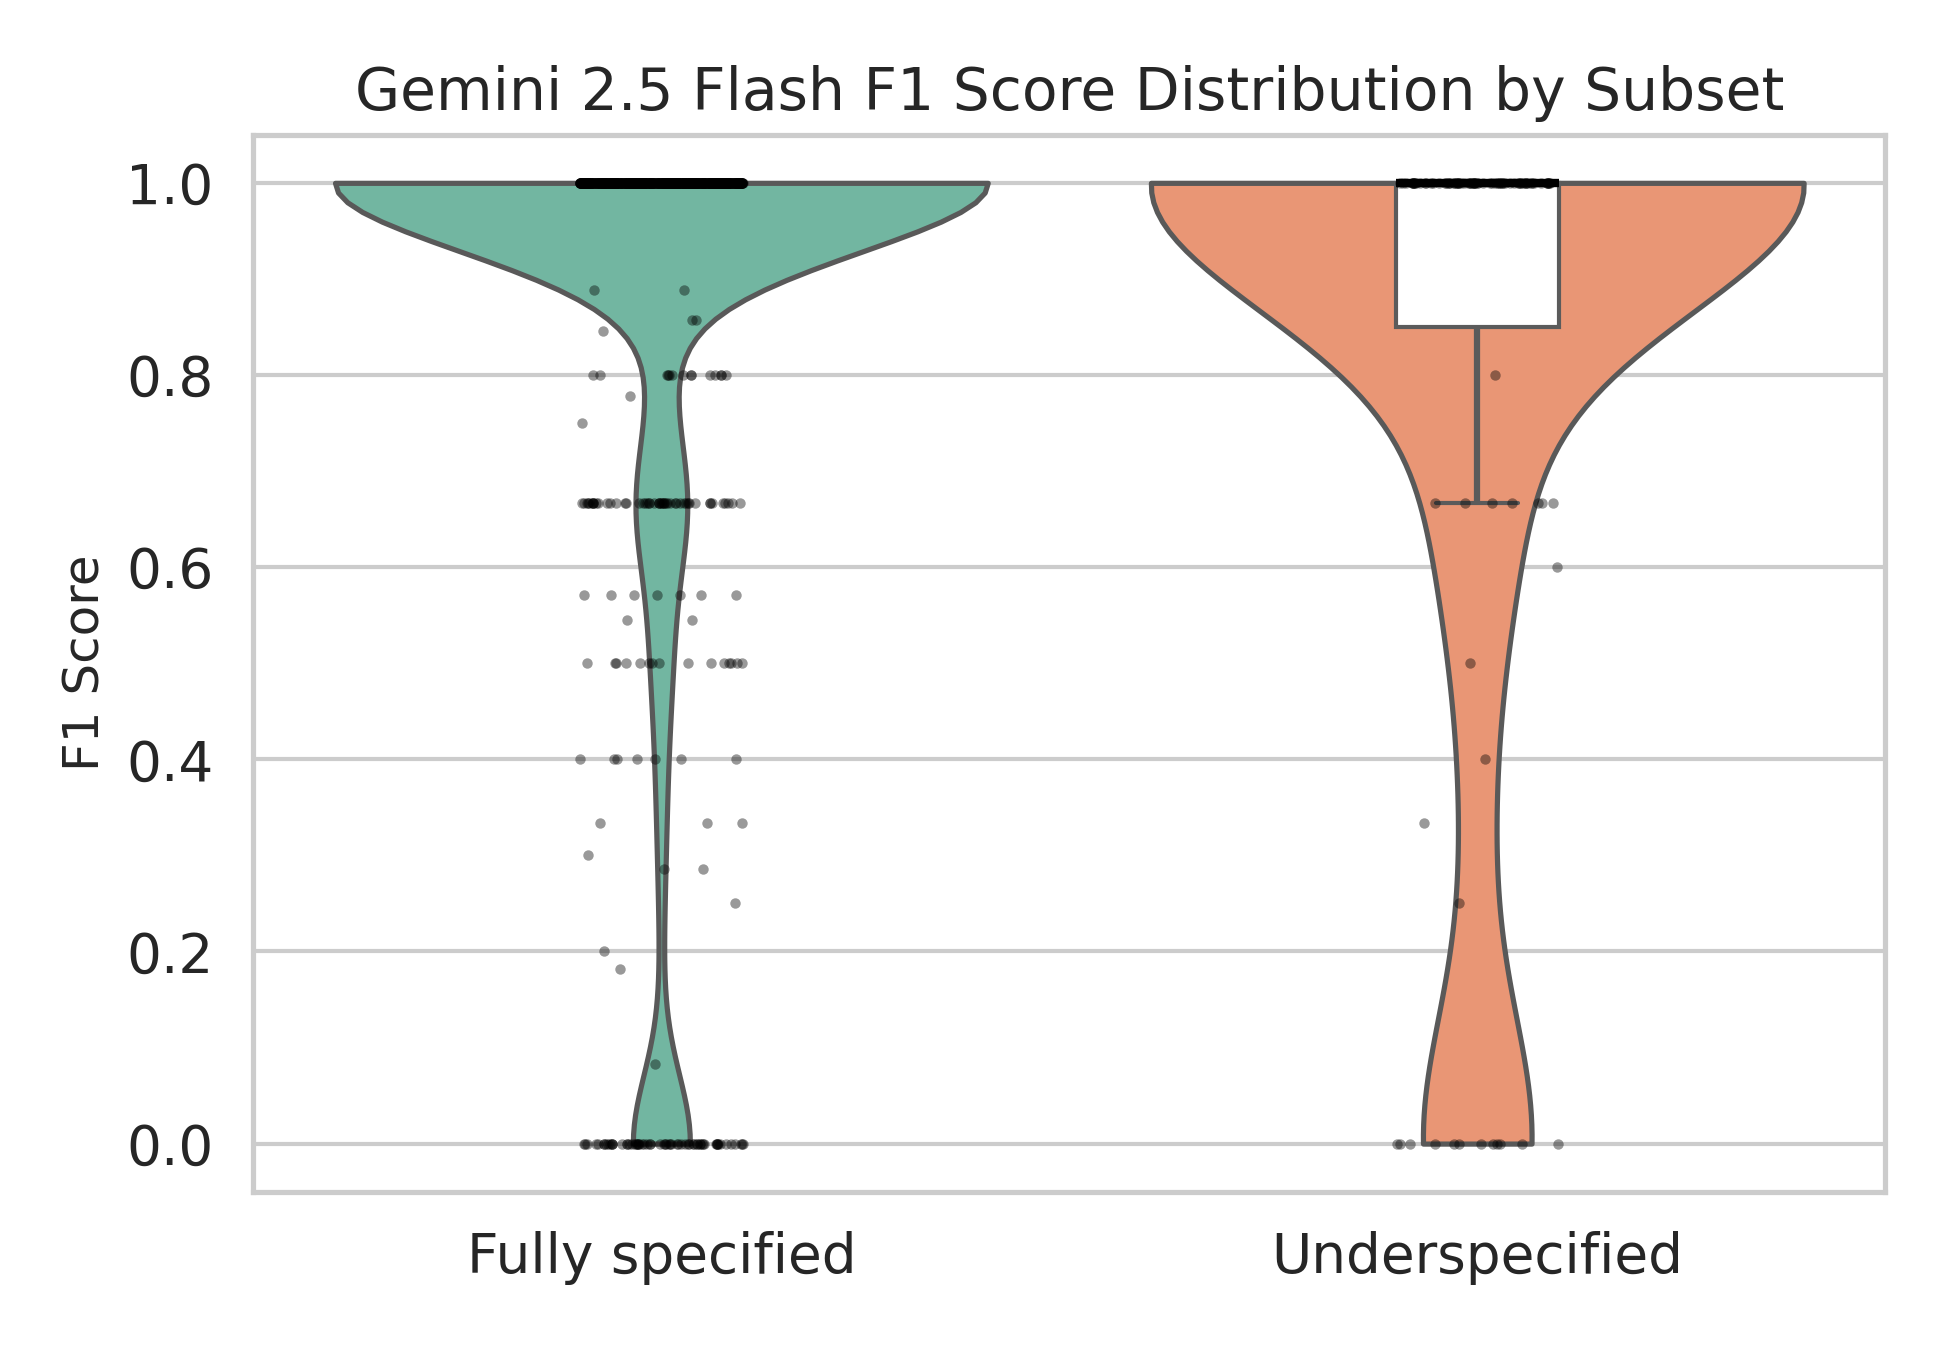

In [26]:
Image("fig_Gemini_f1_by_subset.png")